# Multilayer Perceptron vs Convolutional Neural Nets  - A comparison

This notebook is intended to understand the advantages of Convolutions for extracting abstract features from images in comparison to plain vanilla network. 
I have used MNIST dataset for this comparison.  

## Loading and exploring data

In [487]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets,transforms
from PIL import Image
import pdb
from sklearn.model_selection import train_test_split

In [488]:
path = Path("data/mnist/"); 
test_data_path = path/'test'
train_data_path = path/'train'

In [489]:
train_imgs=[]
train_labels=[]
for item in os.listdir(train_data_path):
    for items in os.listdir(train_data_path/item):
        train_imgs.append(train_data_path/item/items)
        train_labels.append(int(item))

In [490]:
test_imgs=[]
test_labels=[]
for item in os.listdir(test_data_path):
    for items in os.listdir(test_data_path/item):
        test_imgs.append(test_data_path/item/items)
        test_labels.append(int(item))

In [491]:
df_train = pd.DataFrame(list(zip(train_imgs,train_labels)))
df_train.columns = ('path','label')

### Creating validation split from train

In [492]:
X_train,X_val,y_train,y_val=train_test_split(df_train['path'],df_train['label'],test_size=0.2,stratify=df_train['label'])

### Creating dataset and dataloader

In [493]:
class Dataset(torch.utils.data.Dataset):
      
    def __init__(self,features,labels):
        self.features = list(features)
        self.labels = list(labels)
    
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, index):
        trans=transforms.ToTensor()
        img_path = self.features[index]
        img = Image.open(img_path)
        X = trans(img).reshape(-1,1).squeeze()
        y = torch.tensor([self.labels[index]])
        return X,y
    

In [494]:
train_dataset = Dataset(X_train,y_train)
val_dataset= Dataset(X_val,y_val)
test_dataset = Dataset(test_imgs,test_labels)

In [495]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_dataset, batch_size = 64,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size = 64,shuffle=True)

### Creating multilayer perceptron

In [496]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_features,out_size,hid_layers):
        super().__init__()
        
        layers = []
       
        for idx,item in enumerate(hid_layers):
            if idx==0:
                layers.append(nn.Linear(in_features, item))
            else:
                layers.append(nn.Linear(hid_layers[idx-1],item))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hid_layers[-1],out_size))    
        
        self.net = nn.Sequential(*layers)
        
    def forward(self,x): # size of x must be [batch size x 784]
        out  = self.net(x)
        return F.log_softmax(out,dim=1)

In [497]:
params = {'hid_layers':[120,84],
          'input_size':784,
          'out_size':10
         }

### Training parameters

In [498]:
epochs = 50
lr=0.01
criterion = nn.CrossEntropyLoss()
model = MultilayerPerceptron(params['input_size'],params['out_size'],params['hid_layers'])
optimizer= torch.optim.SGD(model.parameters(),lr = lr)

### Defining train and validation cycles

In [499]:
def train(model,train_loader,criterion,optimizer):
    
    model.train() 
    train_losses=[]
    train_acc=[]
    for batch in train_loader:
        x = batch[0]
        y_true  = batch[1]

        if torch.cuda.is_available():
            x  = x.cuda()
            y_true = y_true.cuda()
        
        optimizer.zero_grad()
        y_pred = model.forward(x)
        
        train_loss = criterion(y_pred,y_true.squeeze())
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        
        result=torch.argmax(y_pred,dim=1).reshape(-1,1)
        correct_preds_count = (result==y_true).sum()
        accuracy = correct_preds_count.item() / result.shape[0]
        train_acc.append(accuracy)
     
    return model,np.mean(train_losses), np.mean(train_acc)   

In [500]:
def validation(model,val_loader,criterion):
    model.eval()
    val_losses=[]
    val_acc=[]
    for batch in val_loader:
        x=batch[0]
        y_true=batch[1]
        
        if torch.cuda.is_available():
            x  = x.cuda()
            y_true = y_true.cuda()
        
        y_pred=model.forward(x)
        vali_loss = criterion(y_pred,y_true.squeeze())
        val_losses.append(vali_loss.item())
        
        result=torch.argmax(y_pred,dim=1).reshape(-1,1)
        correct_preds_count = (result==y_true).sum()
        accuracy = correct_preds_count.item() / result.shape[0]
        val_acc.append(accuracy)
        
    return np.mean(val_losses), np.mean(val_acc)  

In [501]:
def do_training (epochs,model,optimizer,criterion,train_loader,val_loader,flag):
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    train_loss_per_epoch = []
    train_acc_per_epoch = []
    val_loss_per_epoch = []
    val_acc_per_epoch = []
    best_val_loss=100000
    for epoch in range(epochs):

        # training cycle
        model,train_loss,train_acc = train(model,train_loader,criterion,optimizer)
        train_loss_per_epoch.append(train_loss)
        train_acc_per_epoch.append(train_acc)
        
        # validation cycle
        val_loss, val_acc = validation(model,val_loader,criterion)
        val_loss_per_epoch.append(val_loss)
        val_acc_per_epoch.append(val_acc)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model_name = f"checkpoints/{flag}/train_loss_{train_loss}_val_loss_{val_loss}.pt"
            torch.save(model.state_dict(),model_name)
                
        print (f"Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")
    
    return train_loss_per_epoch, train_acc_per_epoch, val_loss_per_epoch,val_acc_per_epoch
    

In [502]:
train_loss_per_epoch, train_acc_per_epoch, val_loss_per_epoch,val_acc_per_epoch = do_training(epochs,model,optimizer,criterion,train_loader,val_loader,flag='model1')

Train Loss: 1.9652798530260722, Train Acc: 0.4576875, Val Loss: 1.2039360860560804, Val Acc: 0.7321309840425532
Train Loss: 0.7476864746809005, Train Acc: 0.8159583333333333, Val Loss: 0.5456702805897022, Val Acc: 0.8505651595744681
Train Loss: 0.46449087011814116, Train Acc: 0.8730625, Val Loss: 0.4280315360965881, Val Acc: 0.8818982712765957
Train Loss: 0.3862869633634885, Train Acc: 0.8914166666666666, Val Loss: 0.3786417100023716, Val Acc: 0.8959441489361702
Train Loss: 0.3455706083774567, Train Acc: 0.90225, Val Loss: 0.3481312774201023, Val Acc: 0.9037566489361702
Train Loss: 0.31809753185510636, Train Acc: 0.90975, Val Loss: 0.32423996148591344, Val Acc: 0.91015625
Train Loss: 0.29748752823472024, Train Acc: 0.915625, Val Loss: 0.3104741015729118, Val Acc: 0.9121509308510638
Train Loss: 0.28033324211835864, Train Acc: 0.9197083333333333, Val Loss: 0.29396497747523986, Val Acc: 0.9163065159574468
Train Loss: 0.2657841500540574, Train Acc: 0.9238125, Val Loss: 0.2802444998808998, 

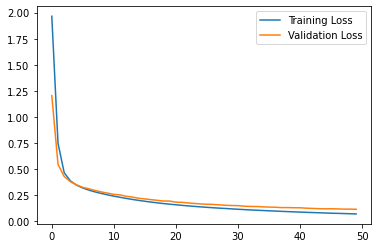

In [503]:
plt.plot(train_loss_per_epoch, label="Training Loss")
plt.plot(val_loss_per_epoch, label="Validation Loss")
plt.legend()

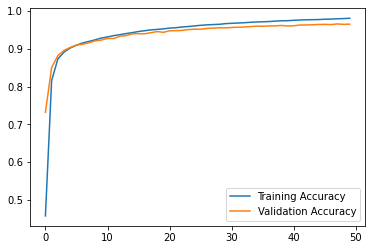

In [504]:
plt.plot(train_acc_per_epoch, label="Training Accuracy")
plt.plot(val_acc_per_epoch, label="Validation Accuracy")
plt.legend()

## Selecting and loading the best model for calculating test accuracy

In [505]:
best_checkpoint = "checkpoints/model1/train_loss_0.06981229243800044_val_loss_0.11426157753003087.pt"

In [506]:
model = MultilayerPerceptron(params['input_size'],params['out_size'],params['hid_layers'])
model.load_state_dict(torch.load(best_checkpoint))
model = model.cuda()

In [507]:
test_loss, test_acc = validation(model,test_loader,criterion)    

In [508]:
print (f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

Test Accuracy: 0.9682523885350318, Test Loss: 0.099841077171361


## Creating Convolution Neural Network

In [464]:
class CNN_Dataset(torch.utils.data.Dataset):
      
    def __init__(self,features,labels):
        self.features = list(features)
        self.labels = list(labels)
    
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, index):
        trans=transforms.ToTensor()
        img_path = self.features[index]
        img = Image.open(img_path)
        X = trans(img)
        y = torch.tensor([self.labels[index]])
        return X,y

In [465]:
train_dataset = CNN_Dataset(X_train,y_train)
val_dataset= CNN_Dataset(X_val,y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_dataset, batch_size = 64,shuffle=True)

In [467]:
class CNN_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,6,3,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        self.fc1=nn.Linear(5*5*16, 120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x,2,2)
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2,2)
        x=x.reshape(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return F.log_softmax(x,dim=1)

In [468]:
model_cnn = CNN_MNIST()
optimizer= torch.optim.SGD(model_cnn.parameters(),lr = lr)

In [469]:
train_loss_per_epoch, train_acc_per_epoch, val_loss_per_epoch,val_acc_per_epoch = do_training(epochs,model_cnn,optimizer,criterion,train_loader,val_loader,flag='model2')

Train Loss: 1.922331678946813, Train Acc: 0.43797916666666664, Val Loss: 0.73146555350816, Val Acc: 0.777842420212766
Train Loss: 0.46225849322477974, Train Acc: 0.8564791666666667, Val Loss: 0.34592067711847896, Val Acc: 0.8935339095744681
Train Loss: 0.2944179628590743, Train Acc: 0.9094375, Val Loss: 0.25044321423356836, Val Acc: 0.9212101063829787
Train Loss: 0.21758299233516057, Train Acc: 0.9325833333333333, Val Loss: 0.20285026582473137, Val Acc: 0.9380817819148937
Train Loss: 0.1729782741094629, Train Acc: 0.9468958333333334, Val Loss: 0.16266700970207124, Val Acc: 0.9486369680851063
Train Loss: 0.14417756089692316, Train Acc: 0.9562083333333333, Val Loss: 0.14662886510028483, Val Acc: 0.9542054521276596
Train Loss: 0.12464586025973161, Train Acc: 0.9612708333333333, Val Loss: 0.12097717618490471, Val Acc: 0.9621010638297872
Train Loss: 0.1118199835854272, Train Acc: 0.9658958333333333, Val Loss: 0.11162407823065494, Val Acc: 0.9647606382978723
Train Loss: 0.10101304619883497, 

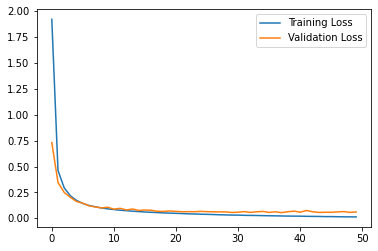

In [470]:
plt.plot(train_loss_per_epoch, label="Training Loss")
plt.plot(val_loss_per_epoch, label="Validation Loss")
plt.legend()

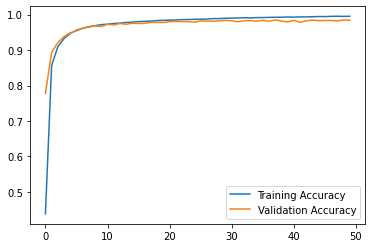

In [471]:
plt.plot(train_acc_per_epoch, label="Training Accuracy")
plt.plot(val_acc_per_epoch, label="Validation Accuracy")
plt.legend()

## Selecting and loading the best model for calculating test accuracy

In [472]:
model_cnn = CNN_MNIST()
best_checkpoint = "checkpoints/model2/train_loss_0.023453963072757083_val_loss_0.05546671626909804.pt"
model_cnn.load_state_dict(torch.load(best_checkpoint))
model_cnn = model.cuda()

In [473]:
test_loss, test_acc = validation(model_cnn,test_loader,criterion)  

In [474]:
print (f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

Test Accuracy: 0.9721337579617835, Test Loss: 0.09880167482551305


## Conclusion:

- CNN converges faster then plain vanilla network
- With equal number of epochs, CNN gave 2% more validation accuracy as compared to vanilla network
